---
## Feature Selection

Neste hands-on, queremos revisitar as técnicas de pré-processamento, como normalizações **(Max-Min, Z-score)** e discretização de dados. Além disso, aprederemos métodos para redução de dimensionalidade (e.g., **PCA**, **t-SNE**, **Isomap**) e seleção de features (e.g., **Information Gain**, **Gini**). Para isso, vamos trabalhar com a base do Titanic que usamos nas atividades anteriores, que estão disponíveis no arquivo **titanic_data.csv**.

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Parte 1 - Pré-processamento

Primeiro, vamos refazer o pré-processamento de dados que haviamos feito anteriormente.

In [3]:
"""Faça a leitura do arquivo salvando seu conteúdo na variável titanic e depois visualize suas 5 primeiras linhas"""
titanic = pd.read_csv('titanic_data.csv')

"""Renomeie as colunas do DataFrame para facilitar o entendimento"""
titanic.columns = ['IdPassageiro','Sobreviveu?','Classe','Nome','Sexo','Idade','Irmãos/Cônjuge','Pais/Crianças','Bilhete','Tarifa','Cabine','Embarque']

""" Tornar a coluna IdPassageiro índice do DataFrame"""
titanic = titanic.set_index('IdPassageiro')

"""Remova as colunas Nome, Bilhete e Cabine do DataFrame"""
titanic.drop(['Nome','Bilhete','Cabine'], axis=1, inplace = True)

titanic.head(5)

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque
IdPassageiro,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 1.1 - Missing Values

In [4]:
""" Verificar se existem valores nulos."""

titanic.isna().sum()

Sobreviveu?         0
Classe              0
Sexo                0
Idade             177
Irmãos/Cônjuge      0
Pais/Crianças       0
Tarifa              0
Embarque            2
dtype: int64

Observe que, dentre os 891 registros do DataFrame, a coluna *Idade* tem 177 valores nulos e a coluna *Embarque* possui 2 valores nulos. No caso do Titanic, pode ser que a idade de certos passageiros fosse desconhecida ou não tenha sido recuperada.

Dados faltantes ou incorretos acontecem com bastante frequência, e é nossa tarefa tratá-los da forma correta. 
Para preencher valores faltantes podemos utilizar diversos métodos, como:
<ul>
    <li> Remoção das linhas que possuem algum valor faltante</li> 
    <li> Subistituição do atributo faltante pela média/mediana/moda dos atributos </li>
</ul>

Neste caso substituíremos os valores faltantes da coluna **Idade** pela **média** das idades dos passageiros. Na coluna **Embarque**, por sua vez, não faz sentido calcular a média/mediana de dados categóricos. Por isso, iremos substituir os valores pela **moda** (valor mais frequente).

In [5]:
"""Verificar as estatísticas do DataFrame."""

titanic.describe()

,Sobreviveu?,Classe,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
"""Substituir os valores nulos de Idade pela média da coluna."""

titanic['Idade'].fillna(titanic['Idade'].mean(), inplace = True)
titanic.isna().sum()

Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          2
dtype: int64

In [7]:
"""Substituir os valores nulos de Embarque pela moda da coluna."""
print('Moda: ', titanic['Embarque'].dropna().mode()[0])
titanic['Embarque'].fillna(titanic['Embarque'].mode()[0], inplace = True)
titanic.isna().sum()

Moda:  S


Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          0
dtype: int64

### 1.2 - Discretização de Dados Numéricos

A discretização de dados pode ajudar bastante quando temos dados numéricos e queremos quebrar os valores em intervalos que representam diferentes categorias. Esse processo pode ser útil em situações onde os dados da coluna não tem correlação com a coluna target. Dessa forma, discretizar os dados pode trazer evidências que não eram tão claras anteriormente.

Se verificarmos a correlação da coluna **Idade** com a coluna **Sobreviveu?**, por exemplo, vemos que praticamente não há correlação. 

In [8]:
"""Correlação entre Idade e Sobrevivência."""

titanic['Idade'].corr(titanic['Sobreviveu?'])

-0.06980851528714313

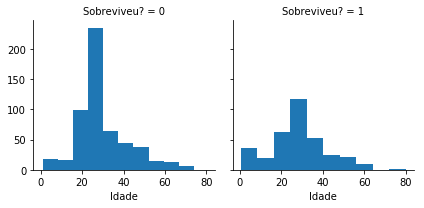

In [9]:
"""Relação entre Idade e Sobrevivência."""

import seaborn as sns
g = sns.FacetGrid(titanic, col='Sobreviveu?')
g.map(plt.hist, 'Idade', bins=10)

Agora, vamos discretizar a coluna **Idade** em 4 categorias: Criança, Jovem, Adulto, Idoso. Depois, vamos analisar a distribuição de sobreviventes em cada categoria.

In [10]:
""" Criar uma nova coluna 'IdadeDisc' no DataFrame com os valores normalizados da coluna Idade. Regras:
    - Para pessoas entre 0 e 15 anos, atribuir o valor 'Criança'.
    - Para pessoas entre 15 e 25 anos, atribuir o valor 'Jovem'.
    - Para pessoas entre 25 e 60 anos, atribuir o valor 'Jovem'.
    - Para pessoas com mais de 60 anos, atribuir o valor 'Idoso'. """

titanic['IdadeDisc'] = pd.cut(titanic['Idade'], bins = [0,15, 25, 60, 80], 
                              labels=['Criança', 'Jovem', 'Adulto', 'Idoso'])
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc
IdPassageiro,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem
2,1,1,female,38.0,1,0,71.2833,C,Adulto
3,1,3,female,26.0,0,0,7.9250,S,Adulto
4,1,1,female,35.0,1,0,53.1000,S,Adulto
5,0,3,male,35.0,0,0,8.0500,S,Adulto


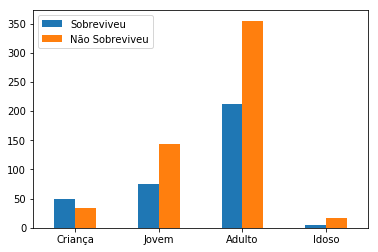

In [11]:
"""Relação entre IdadeDisc e Sobrevivência."""

survived = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('IdadeDisc')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived,
                   'Não Sobreviveu': not_survived}, index=index)
ax = df.plot.bar(rot=0)

Outra coluna que pode ser discretizada é a **Tarifa**. Essa coluna poderia ser categorizada em três grupos de acordo com a faixa de preço: *Barato*, *Médio* e *Caro*. Neste caso, podemos simplesmente distribuir os preços de acordo com o quantil, de forma que cada grupo contenha aproximadamente a mesma quantidade de registros ao final. 

Para isso, podemos utilizar a função **qcut()** do Pandas.

In [12]:
"""Correlação entre Tarifa e Sobrevivência."""
titanic['Tarifa'].corr(titanic['Sobreviveu?'])

0.2573065223849623

In [13]:
"""Gerar intervalos que deixam a distribuição mais equilibrada."""

intervals = pd.qcut(titanic['Tarifa'], 3).astype(str).unique()
intervals

array(['(-0.001, 8.662]', '(26.0, 512.329]', '(8.662, 26.0]'],
      dtype=object)

In [14]:
titanic['Tipo_Tarifa'] = pd.qcut(titanic['Tarifa'], 3).astype(str).map( {intervals[0]: 'Barato', 
                                                                         intervals[1]: 'Medio', 
                                                                         intervals[2]: 'Caro'} ).astype(str)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_Tarifa
IdPassageiro,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem,Barato
2,1,1,female,38.0,1,0,71.2833,C,Adulto,Medio
3,1,3,female,26.0,0,0,7.9250,S,Adulto,Barato
4,1,1,female,35.0,1,0,53.1000,S,Adulto,Medio
5,0,3,male,35.0,0,0,8.0500,S,Adulto,Barato


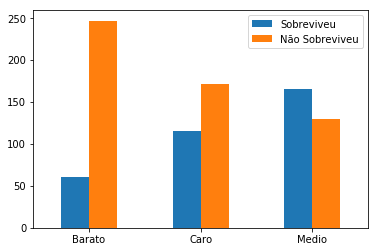

In [15]:
"""Relação entre Tipo da Tarifa e Sobrevivência."""

survived = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_Tarifa')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('Tipo_Tarifa')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_Tarifa')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived,
                   'Não Sobreviveu': not_survived}, index=index)
ax = df.plot.bar(rot=0)

### 1.3 - Transformação de Dados Categóricos

Em muitos casos, o modelo de Machine Learning que usamos para nossa tarefa não aceita dados que não sejam numéricos. Por isso, em vez de ignorar nossos dados categóricos, podemos transformar os dados categóricos em numéricos. Alguns métodos utilizados são:
* **One-hot Encoding** - Transformar cada categoria em uma coluna (*dummy variables*) que contém 1 ou 0, indicando se o registro pertence ou não àquela categoria.
* **Mapeamento** - Mapear cada categoria para um valor inteiro (0,1,2,3...). Quando o número de categorias é 2 apenas, o método geralmente é chamado de **Binarização**.

Cada um dos métodos tem suas peculiaridades. O **One-hot Encoding** aumenta o número de dimensões no espaço de features, o que pode ser muito ruim para casos onde o número de categorias é grande. Por outro lado, o **Mapeamento** pode trazer ruído para o modelo, já que os números não representam números de verdade (Operações como média não fazem sentido, por exemplo).

No caso do Titanic, vamos transformar as colunas categóricas ('Sexo', 'Embarque', 'IdadeDisc' e 'Tipo_Tarifa') em dados numéricos utilizando **Mapeamento** para 'Sexo' e 'Embarque' e **One-hot Encoding** para 'IdadeDisc' e 'Tipo_Tarifa'. 

In [16]:
"""Mapeamento para valores numéricos nas colunas 'Sexo' e 'Embarque'."""

titanic['Sexo'] = titanic['Sexo'].map( {'female': 0, 'male': 1} ).astype(int)
titanic['Embarque'] = titanic['Embarque'].map( {'S': 0, 'C': 1, 'Q':2} ).astype(int)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_Tarifa
IdPassageiro,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,Jovem,Barato
2,1,1,0,38.0,1,0,71.2833,1,Adulto,Medio
3,1,3,0,26.0,0,0,7.9250,0,Adulto,Barato
4,1,1,0,35.0,1,0,53.1000,0,Adulto,Medio
5,0,3,1,35.0,0,0,8.0500,0,Adulto,Barato


In [17]:
"""One-hot Encoding para valores numéricos nas colunas 'IdadeDisc' e 'Tipo_Tarifa'."""

dummy = pd.get_dummies(titanic['IdadeDisc'])
titanic = pd.concat([titanic, dummy], axis=1)

dummy = pd.get_dummies(titanic['Tipo_Tarifa'])
titanic = pd.concat([titanic, dummy], axis=1)

titanic.drop(['IdadeDisc', 'Tipo_Tarifa'], axis=1, inplace=True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
IdPassageiro,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
2,1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0,0,1
3,1,3,0,26.0,0,0,7.9250,0,0,0,1,0,1,0,0
4,1,1,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,0,1,0,1,0,0


### 1.4 - Normalização Min-Max $[0,1]$ 

Antes de realizar as normalizações, vamos remover a coluna 'Sobreviveu?' do nosso DataFrame e salvá-la em uma variável.

In [18]:
"""Remover coluna target antes de normalizar."""

target = titanic['Sobreviveu?']
titanic.drop(['Sobreviveu?'], axis=1, inplace=True)
target.head()

IdPassageiro
1    0
2    1
3    1
4    1
5    0
Name: Sobreviveu?, dtype: int64

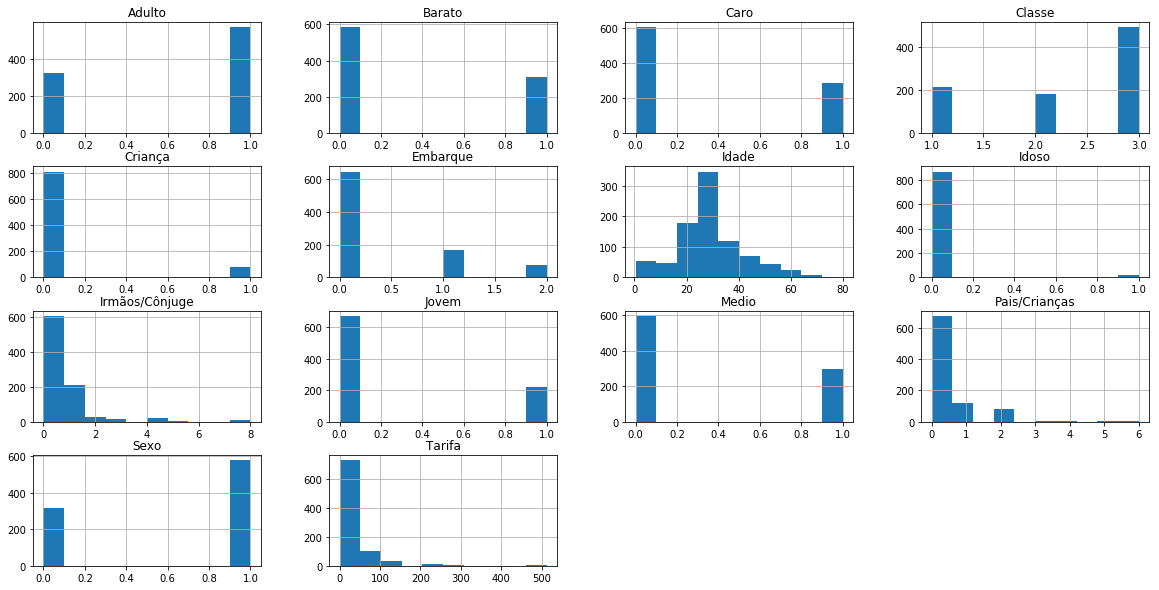

In [27]:
"""Vamos ver a distribuição dos dados antes da normalização. """
titanic.hist(figsize=(20,10))
plt.show()

Podemos querer normalizar atributos para oberservá-los em um intervalo de valores mais bem controlado. Vamos então normalizar nosso DataSet no intervalo $[0,1]$ utilizando a função **MinMaxScaler()** da biblioteca sklearn, que aplicará a função **min-max**, que é dada pela **fórmula**:

$$v' = \frac{v-min_A}{max_A - min_A}(nmax_A - nmin_A) + nmin_A$$

onde:
* $[nmin_A, nmax_A]$ é o intervalo no qual você deseja normalizar seus dados (no nosso caso, $[0,1]$)
* $min_A$ e $max_A$ são os atuais valores mínimo e máximo da coluna, respectivamente.

Deve-se ressaltar que a função não é aplicada em dados categóricos, logo devemos "cortar" algumas colunas do DataSet para aplicarmos a função.

In [19]:
"""Normalizar os dados utilizando a estratégia Min-max."""

from sklearn import preprocessing
X = titanic.values
min_max_scaler = preprocessing.MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(X)
df_minmax = pd.DataFrame(df_minmax,columns=titanic.columns)
df_minmax.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.321438,0.000,0.0,0.015469,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.434531,0.125,0.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.434531,0.000,0.0,0.015713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [20]:
"""Vamos ver como ficam a distribuição de dados do novo DataFrame. """

df_minmax.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,0.65,0.65,0.37,0.07,0.06,0.06,0.18,0.09,0.24,0.64,0.02,0.35,0.32,0.33
std,0.42,0.48,0.16,0.14,0.13,0.10,0.32,0.29,0.43,0.48,0.16,0.48,0.47,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.00,0.27,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.37,0.00,0.00,0.03,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.43,0.12,0.00,0.06,0.50,0.00,0.00,1.00,0.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


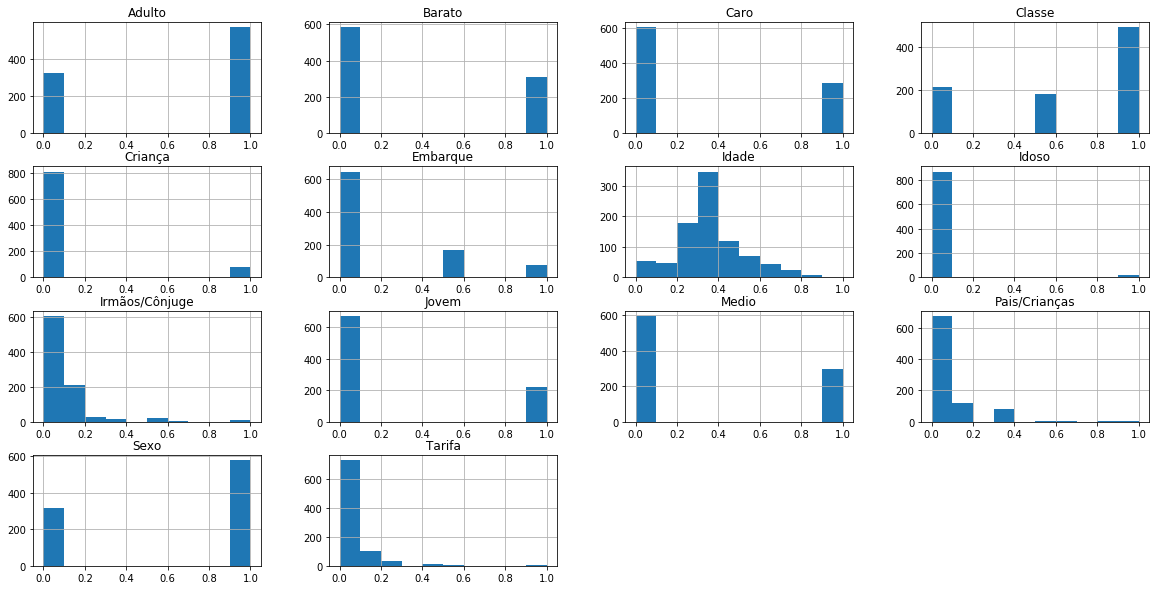

In [21]:
df_minmax.hist(figsize=(20,10))
plt.show()

### 1.5 - Normalização Gaussiana (Z-Score)

Outra maneira de normalizar os dados é utilizando a função **StandardScaler()** da biblioteca sklearn, que normaliza os dados utilizando o **Z-score**:

$$v' = \frac{v-\mu}{\sigma}$$

A seguir, vamos normalizar nossos dados utilizando esse método.

In [22]:
"""Normalizar os dados utilizando o Z-score."""

from sklearn import preprocessing
X = titanic.values
standard_scaler = preprocessing.StandardScaler()
df_standard = standard_scaler.fit_transform(X)
df_standard = pd.DataFrame(df_standard,columns=titanic.columns)
df_standard.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,-0.320504,1.757030,-1.326090,-0.159111,1.375811,-0.691095,-0.703539
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539


In [23]:
"""Mais uma vez vamos ver como ficam a distribuição de dados do novo DataFrame"""

df_standard.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.57,-1.36,-2.25,-0.47,-0.47,-0.65,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
25%,-0.37,-1.36,-0.59,-0.47,-0.47,-0.49,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
50%,0.83,0.74,0.00,-0.47,-0.47,-0.36,-0.57,-0.32,-0.57,0.75,-0.16,-0.73,-0.69,-0.70
75%,0.83,0.74,0.41,0.43,-0.47,-0.02,1.01,-0.32,-0.57,0.75,-0.16,1.38,1.45,1.42
max,0.83,0.74,3.87,6.78,6.97,9.67,2.58,3.12,1.76,0.75,6.28,1.38,1.45,1.42


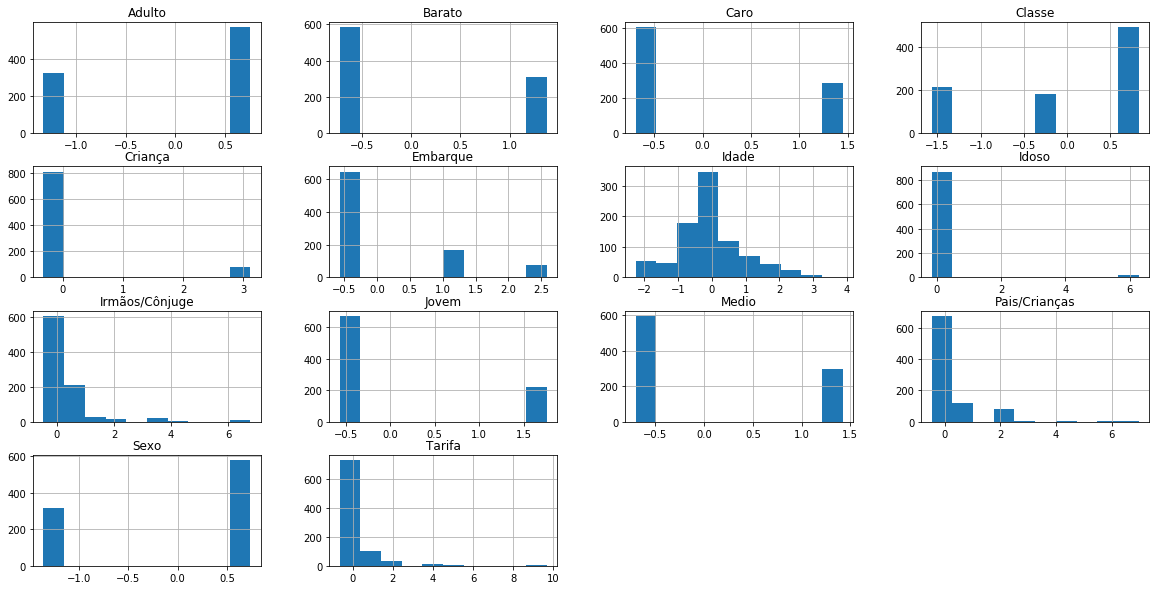

In [24]:
df_standard.hist(figsize=(20,10))
plt.show()

##  Parte 2 - Redução de Dimensionalidade

### 2.1 - PCA

O **PCA** (Principal Component Analysis), método de redução de dimensionalidade que utilizaremos mais adiante, deve ser aplicado apenas em dados numéricos. Portanto, devemos ter certeza de que todas as colunas do nosso dataframe satisfazem a este requisito.

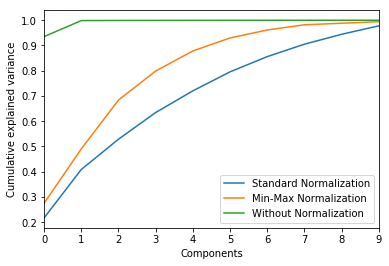

In [26]:
"""Aplicar PCA em cada um dos dataframes normalizados."""

from sklearn.decomposition import PCA

X = df_standard.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard Normalization')

X = df_minmax.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Min-Max Normalization')

X = titanic.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Without Normalization')

plt.xlim(0,9,1)
plt.xlabel('Components')
plt.ylabel('Cumulative explained variance')
plt.legend()

A normalização é muito importante em PCA, já que PCA é um exercício de maximização da variância. Ele projeta seus dados originais em direções que maximizam a variância. O gráfico acima mostra a quantidade de variância total explicada nos diferentes componentes principais. Como você pode ver, quando não há normalização parece que a primeira componente sozinha explica quase toda a variação nos dados. Por outro lado, quando há a normalização as outras componentes também contribuem bastante. 

A razão para isso é porque o PCA procura maximizar a variação de cada componente. Vamos ver como é a variância de cada coluna antes da normalização:

In [76]:
"""Variância de cada coluna do DataFrame. """

titanic.var().sort_values(ascending=False)

Tarifa            2469.436846
Idade              169.052400
Irmãos/Cônjuge       1.216043
Classe               0.699015
Pais/Crianças        0.649728
Embarque             0.404081
Adulto               0.231357
Sexo                 0.228475
Barato               0.226439
Medio                0.221718
Caro                 0.218999
Jovem                0.185014
Criança              0.084571
Idoso                0.024109
dtype: float64

Como a variância da coluna **Tarifa** é muito maior que as demais, o PCA irá preferir fazer a projeção dos pontos na direção de **Tarifa**. Portanto, realizar o PCA sem normalização pode trazer um resultado ruim.

Agora que reduzimos a dimensionalidade dos dados, podemos gerar uma visualização aproximada de como os pontos estão distribuídos no espaço, utilizando a função abaixo. A função **plot_scatter** recebe como parâmetro um DataFrame **data_pca** com 3 colunas, **PC1, PC2, target**. Você deve converter o numpy.ndarray obtido anteriormente em um DataFrame de mesma configuração para que possa utilizar a função e gerar o scatter plot.

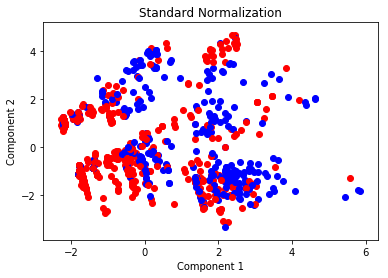

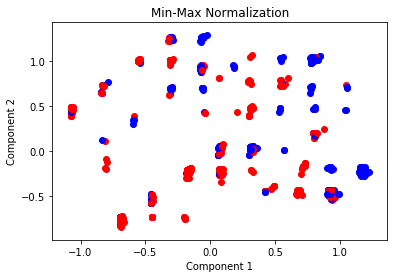

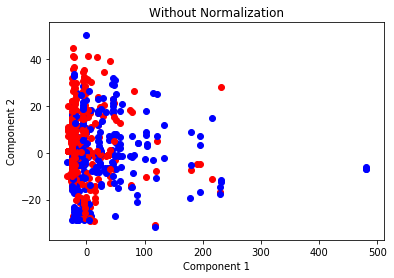

In [77]:
"""Scatter plot dos DataFrames normalizados, após redução de dimensionalidade com PCA. """

def plot_scatter(pca_data, target, title=''):
    colors = ['red', 'blue']
    for x, y in zip(pca_data, target):
        plt.scatter(x[0], x[1], label=y, color=colors[y])
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    return plt.show()

X = df_standard.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Standard Normalization')

X = df_minmax.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')

X = titanic.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Without Normalization')

### 2.2 - t-SNE  (t-distributed Stochastic Neighbor Embedding)

**t-SNE**(t-Distributed Stochastic Neighbor Embedding) é outra técnica para redução de dimensionalidade e é geralmente adequada para a visualização de conjuntos de dados de alta dimensão. Ao contrário do PCA, não é uma técnica matemática, mas sim uma técnica probabilística. 

Essa técnica minimiza a divergência entre as duas distribuições: uma distribuição que mede semelhanças entre pares dos objectos de entrada e uma distribuição que mede semelhanças emparelhados entre o correspondentes pontos de baixa dimensão na incorporação”. Essencialmente, o que isso significa é que ele analisa os dados originais inseridos no algoritmo e analisa a melhor forma de representar esses dados usando menos dimensões, combinando as duas distribuições. 

Pontos Importantes:

* O t-SNE não retém distâncias, mas probabilidades. Portanto, medir algum erro entre as distâncias euclidianas em D alto e baixo D é inútil. Assim, a normalização dos dados não ajuda neste caso.

* Computacionalmente falando, o t-SNE é pesado e, portanto, há algumas limitações (sérias) ao uso dessa técnica. Por exemplo, uma das recomendações é que, no caso de dados dimensionais muito altos, você pode precisar aplicar outra técnica de redução de dimensionalidade antes de usar o t-SNE:

* Segundo o paper: "É altamente recomendável usar outro método de redução dimensionalidade (por exemplo, PCA para dados densas ou TruncatedSVD para dados esparso) para reduzir o número de dimensões de uma quantidade razoável (por exemplo 50), se o número de features é muito elevado."

* Como escolher o melhor valor para o parâmetro 'perplexity'? O desempenho do t-SNE é bastante robusto sob diferentes configurações da perplexidade. O valor mais apropriado depende da densidade dos seus dados. Pode-se dizer que um conjunto de dados maior/mais denso requer uma maior perplexidade. Valores típicos para a perplexidade variam entre 5 e 50.


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.001s...
[t-SNE] Computed neighbors for 891 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.362869
[t-SNE] KL divergence after 300 iterations: 0.962090


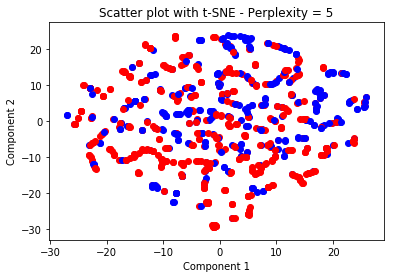

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.000s...
[t-SNE] Computed neighbors for 891 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 1.165312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.178844
[t-SNE] KL divergence after 300 iterations: 0.377720


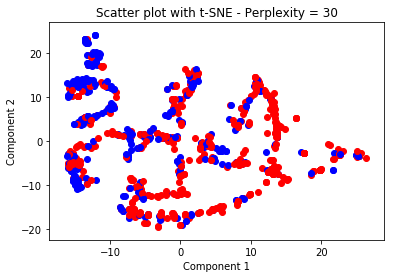

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.000s...
[t-SNE] Computed neighbors for 891 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 1.912064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.812881
[t-SNE] KL divergence after 300 iterations: 0.299733


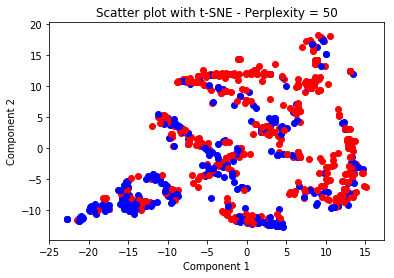

In [78]:
"""Scatter plots do DataFrame, após reduzir a dimensionalidade com t-SNE. """

from sklearn.manifold import TSNE
X = titanic.values
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 5')

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 30')

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 50')


### 2.3 - Isomap

O **Isomap (Isometric Feature Mapping)**, diferentemente da análise de componente principal, é um método de redução de característica não linear. O Isomap deve ser usado quando há um mapeamento não linear entre seus dados de dimensão mais alta e sua variedade de menor dimensão (por exemplo, dados em uma esfera).
Lembre-se de que, se seus dados não estiverem na mesma escala, pode ser necessário dimensionar antes dessa etapa.

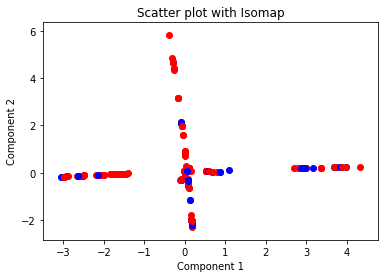

In [60]:
"""Scatter plots do DataFrame, após reduzir a dimensionalidade com Isomap. """

from sklearn.manifold import Isomap
X = df_minmax.values
isomap = Isomap(n_components=2)
data = isomap.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with Isomap')

##  Parte 3 - Feature Selection

### 3.1 - Information Gain (Decision Tree)

In [ ]:
"""Utilizar árvore de decisão para selecionar fetures de acordo com o Information Gain."""

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(titanic,target)
print(dtree.feature_importances_)
feat_importances = pd.Series(dtree.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[0.08206444 0.23801931 0.2511757  0.03063121 0.0212509  0.31771678
 0.0278354  0.01224189 0.00585035 0.0107594  0.         0.
 0.         0.00245463]


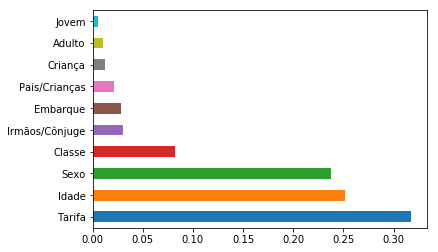

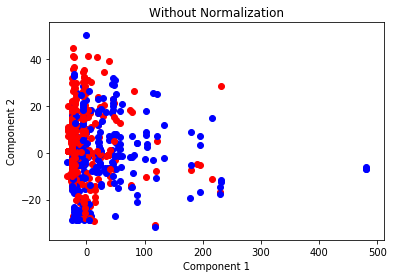

In [95]:
"""Scatter plot do Dataframe utilizando somente as principais features selecionadas."""
X = titanic[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Without Normalization')
plt.show()

[0.08021087 0.23801931 0.26112837 0.02895216 0.02428125 0.29931278
 0.03886441 0.         0.00648876 0.01300455 0.         0.00883221
 0.         0.00090533]


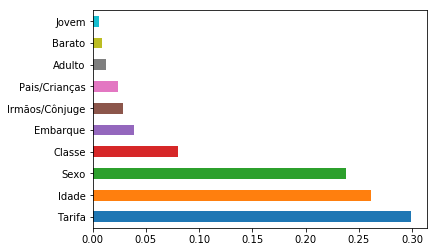

In [97]:
"""Utilizar árvore de decisão para selecionar fetures de acordo com o Information Gain, 
    mas agora a paritir do dataframe normalizado."""

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(df_minmax,target)
print(dtree.feature_importances_)

feat_importances = pd.Series(dtree.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

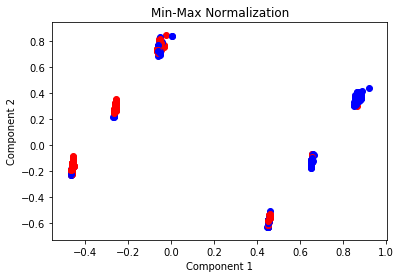

In [98]:
"""Scatter plot do Dataframe utilizando somente as principais features selecionadas."""
X = df_minmax[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')
plt.show()

### 3.2 - Gini (Random Forest)

[0.06262653 0.25343678 0.23421043 0.05276691 0.03354983 0.26260031
 0.02831054 0.00866743 0.01006901 0.01689401 0.00347749 0.00984653
 0.00832349 0.01522071]


/Users/alefmonteiro/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


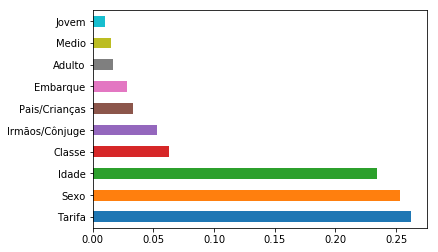

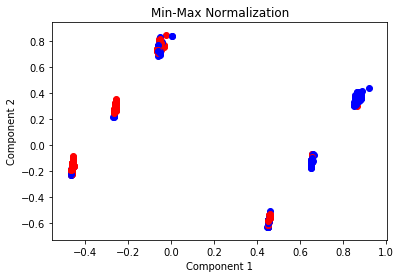

In [96]:
"""Utilizar random forests para selecionar fetures de acordo com a Gini."""

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini')
clf.fit(df_minmax, target)
print(clf.feature_importances_)
feat_importances = pd.Series(clf.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

"""Scatter plot do Dataframe utilizando somente as principais features selecionadas."""
X = df_minmax[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')
plt.show()

### 3.3 - Outras Técnicas

### 3.3.1 - Chi-Square

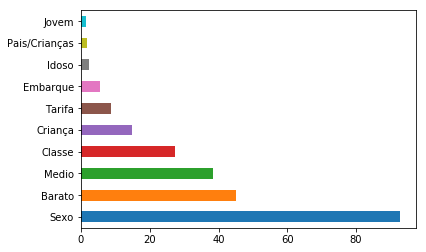

In [83]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

X = df_minmax.values
bestfeatures = SelectKBest(score_func=chi2, k=10)
feature_importances = bestfeatures.fit(X,target).scores_

feat_importances = pd.Series(feature_importances, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

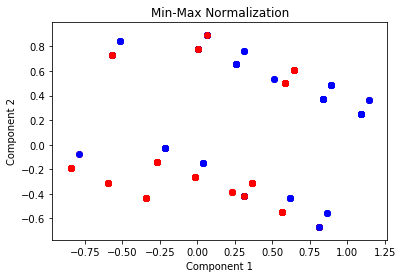

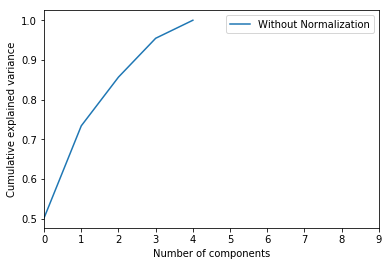

In [84]:
X = df_minmax[['Sexo', 'Barato', 'Medio', 'Classe', 'Criança']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')

pca = PCA(n_components=5)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Without Normalization')
plt.xlim(0,9,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()

### 3.3.2 - Matriz de Correlações

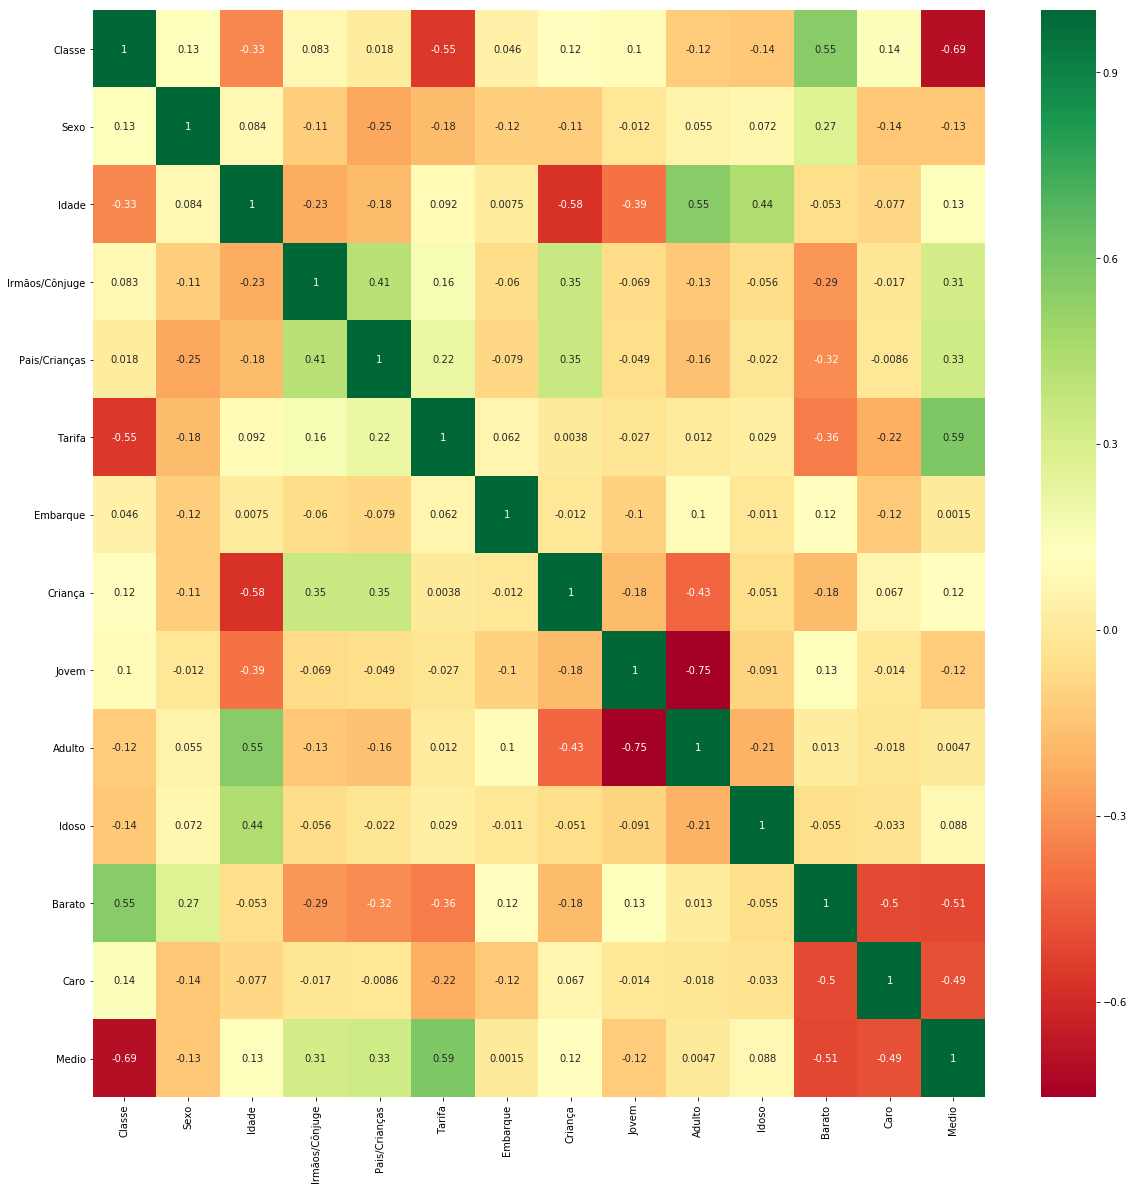

In [73]:
#get correlations of each features in dataset
corrmat = titanic.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(titanic[top_corr_features].corr(),
              annot=True,cmap="RdYlGn")